In [28]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import json
from dotenv import load_dotenv
import os

load_dotenv()
MONGODB_URI = os.getenv("MONGODB_URI")

In [30]:
client = MongoClient(MONGODB_URI)
db = client["dev_v2"]
collection = db["edps_claims-837"]

docs = list(collection.find().limit(2000))
print(f"Loaded {len(docs)} documents")

/tmp/ipykernel_40316/3828201410.py:1: UserWarning: You appear to be connected to a CosmosDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/cosmosdb
  client = MongoClient(MONGODB_URI)


Loaded 2000 documents


In [31]:
def flatten_json(y, prefix=''):
    out = {}
    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], f'{name}{a}_')
        elif isinstance(x, list):
            i = 0
            for a in x:
                flatten(a, f'{name}{i}_')
                i += 1
        else:
            out[f'{name[:-1]}'] = x
    flatten(y, prefix)
    return out

flat_docs = [flatten_json(doc) for doc in docs]
df = pd.DataFrame(flat_docs)
print("Flattened dataframe shape:", df.shape)

Flattened dataframe shape: (2000, 3004)


In [32]:
features = [
    "Provider_BillProv_State",
    "Provider_BillProv_Taxonomy",
    "Provider_BillProv_EntityType",
    "Claim_TotalAmt",
    "Claim_POS",
    "Claim_Frequency",
    "Member_Subscriber_Gender",
    "Member_Subscriber_State",
    "Member_Subscriber_RelshipCode",
]

target = "Diagnosis_Diag_Codes_0_Diagnosis_01"

df = df[features + [target]].dropna(subset=[target])
df[target] = df[target].astype(str)

numeric_fields = ["Claim_TotalAmt", "Claim_POS", "Claim_Frequency"]

for col in numeric_fields:
    # Convert only these fields to float
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "").str.strip(), errors="coerce")

# All others remain categorical (string)
for col in df.columns:
    if col not in numeric_fields + [target]:
        df[col] = df[col].astype(str)

X = df[features]
y = df[target]

cat_cols = [col for col in features if col not in numeric_fields]
num_cols = numeric_fields

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

Categorical: ['Provider_BillProv_State', 'Provider_BillProv_Taxonomy', 'Provider_BillProv_EntityType', 'Member_Subscriber_Gender', 'Member_Subscriber_State', 'Member_Subscriber_RelshipCode']
Numerical: ['Claim_TotalAmt', 'Claim_POS', 'Claim_Frequency']


In [33]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    random_state=42
)

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", tree)
])

In [35]:
# Drop classes that appear only once
y_counts = y.value_counts()
rare_classes = y_counts[y_counts < 2].index
mask = ~y.isin(rare_classes)

x_filtered = X[mask]
y_filtered = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    x_filtered, y_filtered, test_size=0.2, stratify=y_filtered, random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


=== Classification Report ===
              precision    recall  f1-score   support

        A419       0.00      0.00      0.00         1
        B351       0.00      0.00      0.00         1
        C155       0.00      0.00      0.00         1
        C187       0.00      0.00      0.00         1
        C250       0.00      0.00      0.00         1
       C3411       0.00      0.00      0.00         1
       C3490       0.00      0.00      0.00         1
       C4492       0.00      0.00      0.00         1
         C61       0.00      0.00      0.00         3
        C773       0.00      0.00      0.00         1
        C787       0.00      0.00      0.00         1
       C9110       0.00      0.00      0.00         1
        D509       0.00      0.00      0.00         2
        D692       0.00      0.00      0.00         2
        E039       0.00      0.00      0.00         2
        E042       0.00      0.00      0.00         1
       E1042       0.00      0.00      0.00       

/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/home/linux-dex/Documents/HDM/logistic_regression/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="

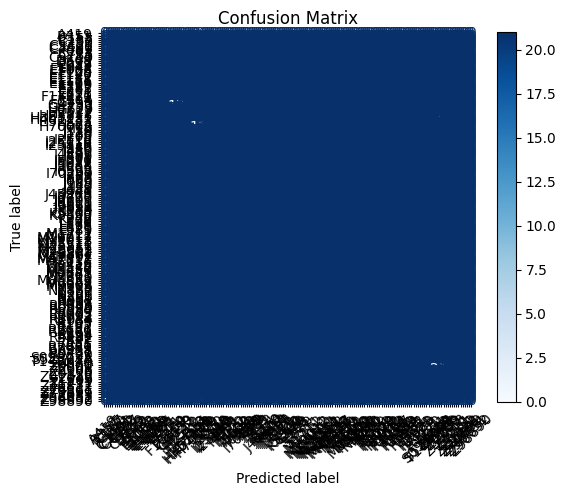

In [36]:
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

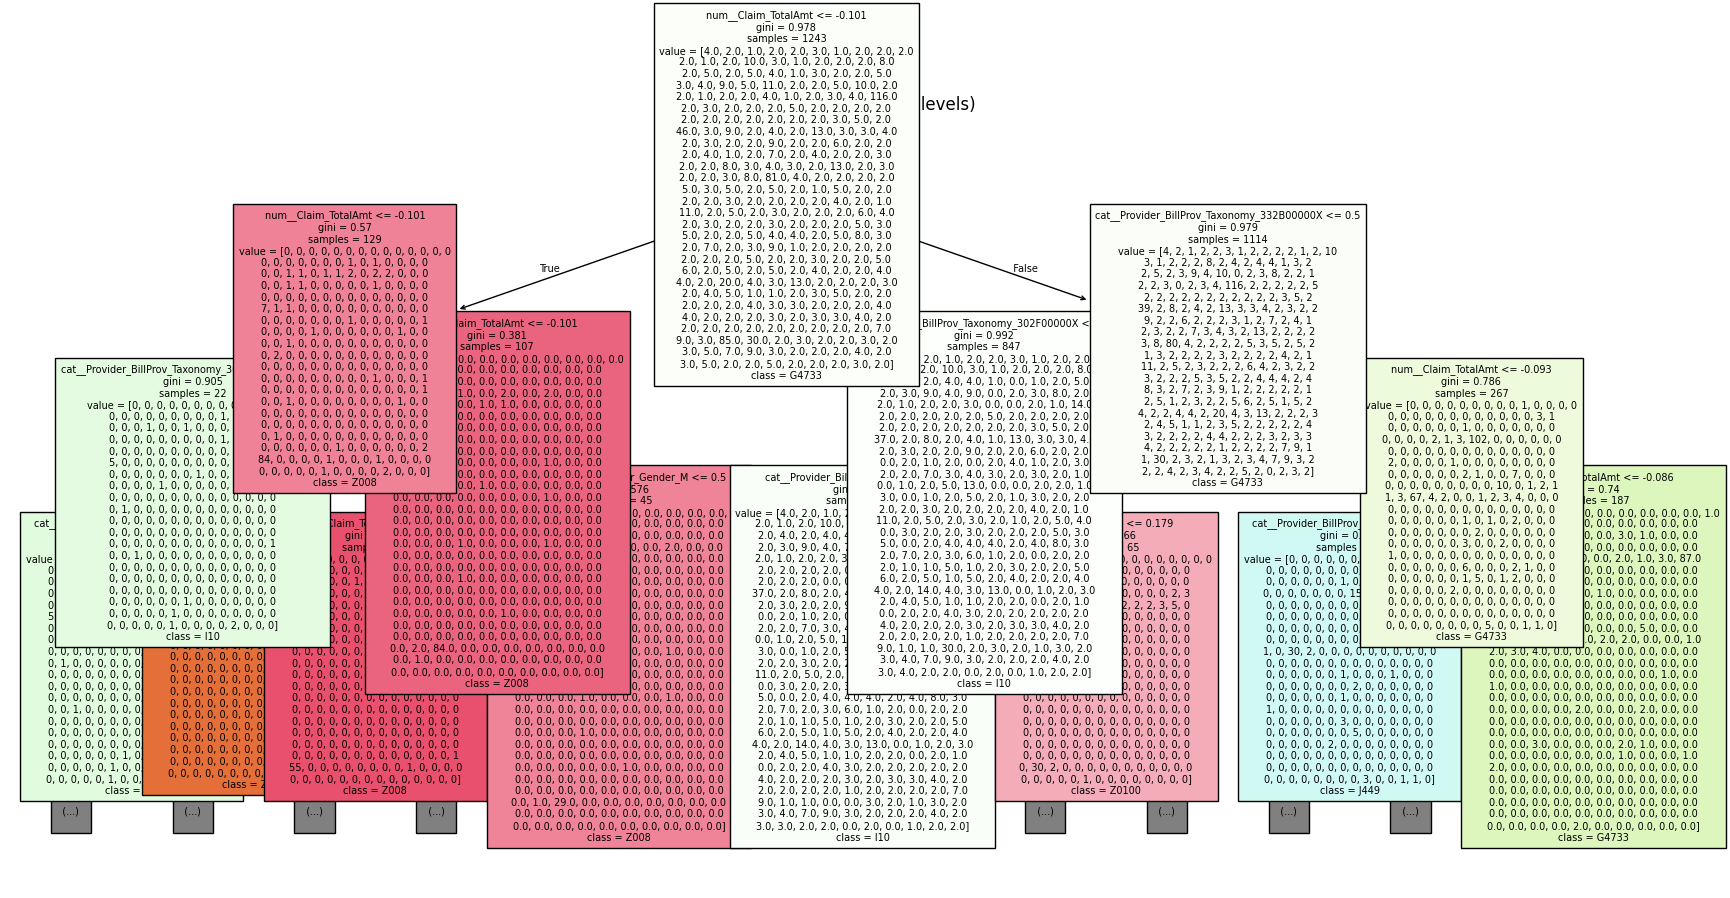

In [37]:
# Extract fitted DecisionTree from pipeline
fitted_tree = model.named_steps["clf"]
preprocessor = model.named_steps["preprocess"]

# Get feature names after one-hot encoding
encoded_features = preprocessor.get_feature_names_out()
plt.figure(figsize=(22, 10))
plot_tree(
    fitted_tree,
    feature_names=encoded_features,
    class_names=np.unique(y_train),
    filled=True,
    fontsize=7,
    max_depth=3
)
plt.title("Decision Tree (top 3 levels)")
plt.show()

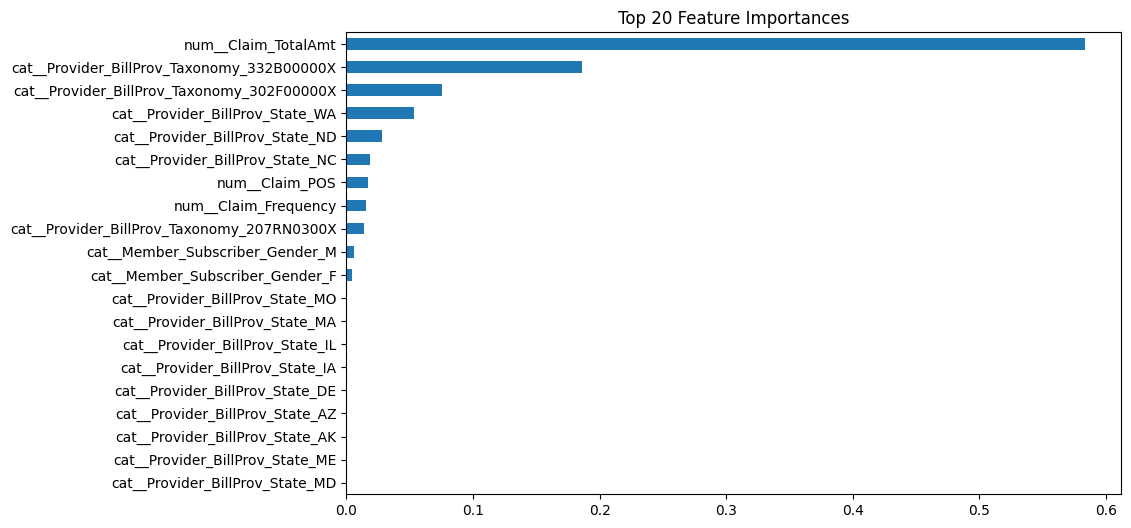

In [38]:
importances = pd.Series(
    fitted_tree.feature_importances_,
    index=encoded_features
).sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 6))
importances.plot(kind="barh")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
joblib.dump(model, "diagnosis_tree_model.joblib")
print("Model saved to diagnosis_tree_model.joblib")

In [ ]:
sample = X_test.iloc[[0]]
pred_diag = model.predict(sample)[0]
print("\nSample input:")
print(sample)
print("Predicted Diagnosis Code:", pred_diag)